In [5]:
from model import load_model
import numpy as np
from typing import Dict, Any, List
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

face_model = load_model()

In [6]:
import zipfile
import os

zip_file_name = "id_samples.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('id_samples')

zip_file_name = "test_samples.zip"
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('test_samples')

In [7]:
!unzip id_samples.zip
!unzip test_samples.zip

Archive:  id_samples.zip
  inflating: id_samples/Abbas_Kiarostami_1.jpg  
  inflating: id_samples/Abbas_Kiarostami_2.jpg  
  inflating: id_samples/Abbas_Kiarostami_3.jpg  
  inflating: id_samples/Abdullah_Gul_1.jpg  
  inflating: id_samples/Abdullah_Gul_2.jpg  
  inflating: id_samples/Abdullah_Gul_3.jpg  
  inflating: id_samples/Abdullah_al-Attiyah_1.jpg  
  inflating: id_samples/Abdullah_al-Attiyah_2.jpg  
  inflating: id_samples/Abdullah_al-Attiyah_3.jpg  
  inflating: id_samples/Adel_Al-Jubeir_1.jpg  
  inflating: id_samples/Adel_Al-Jubeir_2.jpg  
  inflating: id_samples/Adel_Al-Jubeir_3.jpg  
  inflating: id_samples/Adrian_McPherson_1.jpg  
  inflating: id_samples/Adrian_McPherson_2.jpg  
  inflating: id_samples/Adrian_McPherson_3.jpg  
  inflating: id_samples/Afton_Smith_1.jpg  
  inflating: id_samples/Afton_Smith_2.jpg  
  inflating: id_samples/Afton_Smith_3.jpg  
  inflating: id_samples/Aishwarya_Rai_1.jpg  
  inflating: id_samples/Aishwarya_Rai_2.jpg  
  inflating: id_samples/A

In [8]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.spatial.distance import cdist
from PIL import Image
import os
import random

In [66]:
class LowQualityTransform:
    def __init__(self, downscale_factor=0.6, noise_std=0.9, blur_radius=13):
        self.downscale = transforms.Resize((int(256 * downscale_factor), int(256 * downscale_factor)))
        self.upsample = transforms.Resize((256, 256))
        self.noise_std = noise_std
        self.blur = transforms.GaussianBlur(blur_radius)
        self.color_jitter = transforms.ColorJitter(brightness=0.7, contrast=0.6, saturation=0.5, hue=0.3)
        self.random_crop = transforms.RandomResizedCrop(size=(160, 160), scale=(0.7, 0.9))
        self.rand_rotate = transforms.RandomRotation(random.randint(270,360))



    def __call__(self, img):
        img = self.random_crop(img)
        img = self.rand_rotate(img)
        img = self.color_jitter(img)
        img = self.downscale(img)
        img = self.upsample(img)
        img = np.array(img)
        img = img + np.random.normal(0, self.noise_std, img.shape)
        img = np.clip(img, 0, 255).astype(np.uint8)
        img = Image.fromarray(img)
        img = self.blur(img)
        return img

In [67]:
def apply_transform_to_images(image_list, transform):
    transformed_images = []
    for img in image_list:
        transformed_img = transform(img)
        transformed_images.append(transformed_img)
    return transformed_images

In [68]:
def get_image_paths(folder):
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
    return [os.path.join(folder, file) for file in os.listdir(folder) if os.path.splitext(file)[1].lower() in image_extensions]

ood_image_paths = get_image_paths("id_samples")
ood_image_paths

['id_samples/Hee-Won_Han_3.jpg',
 'id_samples/John_Burkett_3.jpg',
 'id_samples/Junichi_Inamoto_1.jpg',
 'id_samples/Martin_Cauchon_1.jpg',
 'id_samples/BJ_Habibie_2.jpg',
 'id_samples/Nicolas_Massu_2.jpg',
 'id_samples/Peter_OToole_1.jpg',
 'id_samples/BJ_Habibie_3.jpg',
 'id_samples/Steve_Nash_3.jpg',
 'id_samples/Doug_Christie_1.jpg',
 'id_samples/Kareena_Kapoor_1.jpg',
 'id_samples/Lew_Rywin_3.jpg',
 'id_samples/Ted_Maher_2.jpg',
 'id_samples/Laura_Schlessinger_3.jpg',
 'id_samples/Matt_Doherty_3.jpg',
 'id_samples/Caroline_Link_2.jpg',
 'id_samples/Javier_Solana_2.jpg',
 'id_samples/Richard_Perle_1.jpg',
 'id_samples/Ion_Iliescu_2.jpg',
 'id_samples/Ari_Fleischer_2.jpg',
 'id_samples/Anthony_Rackauckas_2.jpg',
 'id_samples/Sean_Hayes_1.jpg',
 'id_samples/Guillaume_Soro_1.jpg',
 'id_samples/Ashley_Postell_3.jpg',
 'id_samples/Serge_Tchuruk_3.jpg',
 'id_samples/Akbar_Al_Baker_1.jpg',
 'id_samples/Steven_Hatfill_1.jpg',
 'id_samples/Toni_Jennings_2.jpg',
 'id_samples/Rick_Wagoner_2.j

In [69]:
image_list = [Image.open(path) for path in ood_image_paths]

In [70]:
transform = LowQualityTransform()
transformed_images = apply_transform_to_images(image_list, transform)

In [71]:
import matplotlib.pyplot as plt

def plot_images(original_images, transformed_images):
    num_images = len(original_images)
    plt.figure(figsize=(12, 6))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.title(f"Original {i+1}")
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(transformed_images[i])
        plt.title(f"Transformed {i+1}")
        plt.axis('off')

    plt.show()

In [72]:
import os

save_dir = 'transformed'
transformed_img_paths = []
os.makedirs(save_dir, exist_ok=True)
for idx, img in enumerate(transformed_images):
    image_path = os.path.join(save_dir, f'image_{idx+1}.jpg')
    img.save(image_path)
    transformed_img_paths.append(image_path)

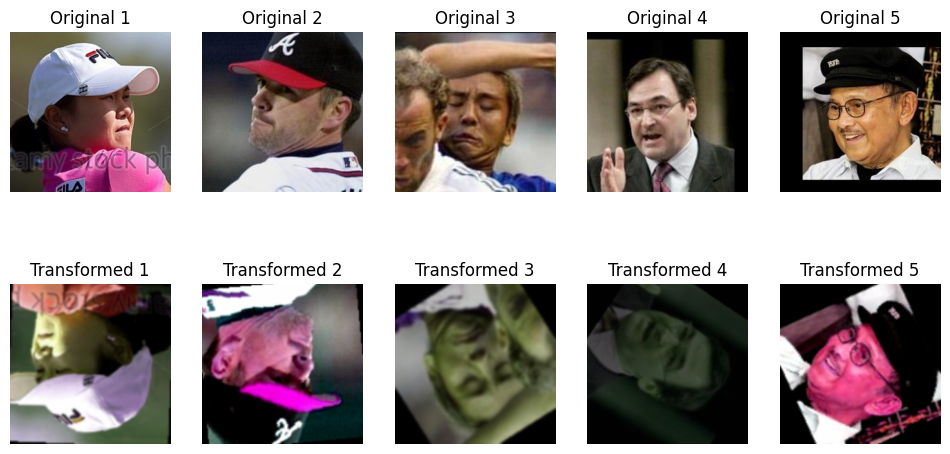

In [73]:
plot_images(image_list[:5], transformed_images[:5])
plt.show()

In [74]:
nature_images = [Image.open(path) for path in get_image_paths("test_samples")]

In [75]:
for img in nature_images:
    img = img.resize((160,160), Image.ANTIALIAS)

<ipython-input-75-4180a8268ce5>:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((160,160), Image.ANTIALIAS)


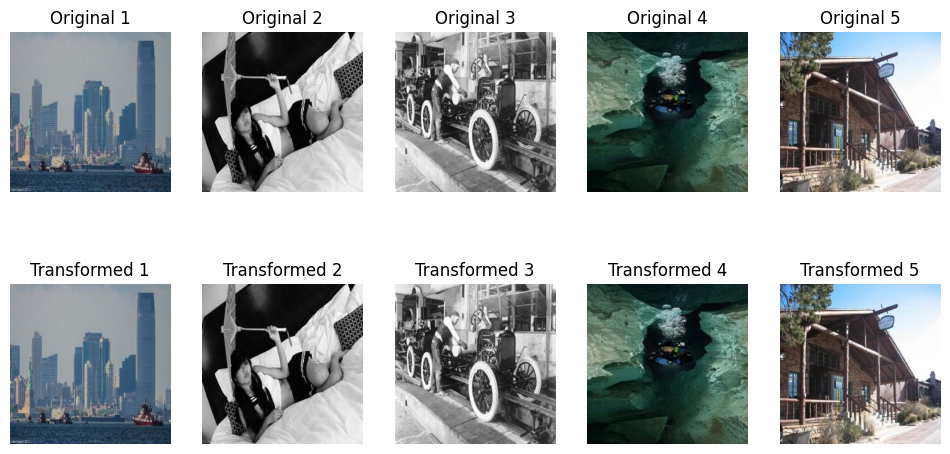

In [76]:
plot_images(nature_images[:5], nature_images[:5])

In [104]:
import random
ood_dataset = random.shuffle(nature_images + transformed_images[:100])
ood_dataset = nature_images + transformed_images[:100]
# ood_dataset

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 <PIL.Jpeg

In [78]:
from utils import compare
res = compare(face_model, 'id_samples/Joan_Dangerfield_1.jpg', 'transformed/image_1.jpg')
res['equal']

True

In [79]:
# transformed_img_paths = get_image_paths("transformed")

In [80]:
count = 0
for tr,orig in zip(transformed_img_paths[:150], ood_image_paths[:150]):
  res = compare(face_model, tr, orig)
  if res['equal']:
    count += 1
count


43

In [81]:
from utils import __find_face, __resize, __forward

In [82]:
__find_face('id_samples/Gholamreza_Aghazadeh_3.jpg')
face = __find_face(img_path='id_samples/Gholamreza_Aghazadeh_3.jpg')
img = face["face"][:, :, ::-1]
target_size = (160, 160)

img = __resize(img, (target_size[1], target_size[0]))
embedding = face_model(img, training=False).numpy()[0]
embedding

array([ 3.41328979e-01, -3.97098549e-02,  5.07112622e-01, -1.01085508e+00,
        3.53873640e-01,  2.76456386e-01,  4.29512739e-01,  4.08332467e-01,
        3.45690548e-02,  6.88084662e-02,  6.19716421e-02,  7.14432120e-01,
       -4.32757735e-02, -2.17908978e-01,  2.81860471e-01, -7.04870939e-01,
       -5.36878467e-01, -4.79413688e-01,  7.56305277e-01, -5.08574367e-01,
       -5.39219022e-01, -2.84228265e-01, -3.41989547e-01,  1.06886244e+00,
        2.66933560e-01, -2.69440174e-01,  7.50426888e-01,  3.29158932e-01,
       -1.04653046e-01, -8.11506510e-01, -6.55092120e-01,  4.48912740e-01,
       -6.13797903e-01, -3.35898787e-01, -5.35377264e-01, -9.81881320e-02,
       -4.26092744e-01,  1.19519979e-03,  1.08703661e+00, -2.41834730e-01,
        1.74842119e-01, -5.03685594e-01,  4.30643439e-01,  1.10591218e-01,
       -2.10133955e-01,  1.20128371e-01, -7.23681211e-01, -1.38961196e+00,
       -3.60343456e-01, -3.39781433e-01, -7.29395032e-01,  1.26573074e+00,
        4.39510465e-01, -

In [85]:
from model import load_model
import numpy as np
from typing import Dict, Any, List
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

face_model = load_model()

def dist(x):
    return (np.linalg.norm(x) - 3) / 9
def __forward(model: Model, img: np.ndarray) -> List[float]:
    return model(img, training=False).numpy()[0]


def compare(model: Model, img1_path: str, img2_path: str) -> Dict[str, Any]:
    emb1 = __calculate_embedding(model, img1_path)
    emb2 = __calculate_embedding(model, img2_path)
    distance = __calculate_cosine(emb1, emb2)
    return {"confidence": 1.0, "distance": distance, "equal": distance <= 0.4}


def __find_face(img_path, model: Model):
    img = cv2.imread(img_path)
    target_size = (160, 160)

    img = __resize(img, (target_size[1], target_size[0]))
    ood = dist(__forward(model, img))
    return {
        "face": img[:, :, ::-1],
        "facial_area": {
            "x": 0,
            "y": 0,
            "w": img.shape[1],
            "h": img.shape[0],
            "left_eye": None,
            "right_eye": None,
            },
        "confidence": 0,
        "ood": ood
    }

def __resize(img, target_size):
    factor_0 = target_size[0] / img.shape[0]
    factor_1 = target_size[1] / img.shape[1]
    factor = min(factor_0, factor_1)

    dsize = (
        int(img.shape[1] * factor),
        int(img.shape[0] * factor),
    )
    img = cv2.resize(img, dsize)

    diff_0 = target_size[0] - img.shape[0]
    diff_1 = target_size[1] - img.shape[1]

    img = np.pad(
        img,
        (
            (diff_0 // 2, diff_0 - diff_0 // 2),
            (diff_1 // 2, diff_1 - diff_1 // 2),
            (0, 0),
        ),
        "constant",
    )

    if img.shape[0:2] != target_size:
        img = cv2.resize(img, target_size)

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    if img.max() > 1:
        img = (img.astype(np.float32) / 255.0).astype(np.float32)

    return img

def __calculate_embedding(model: Model, img_path: str) -> List[float]:
    face = __find_face(img_path=img_path)
    img = face["face"][:, :, ::-1]
    target_size = (160, 160)

    img = __resize(img, (target_size[1], target_size[0]))
    embedding = __forward(model, img)
    return embedding

def __calculate_cosine(emb1, emb2) -> np.float64:
    a = np.matmul(np.transpose(emb1), emb2)
    b = np.sum(np.multiply(emb1, emb1))
    c = np.sum(np.multiply(emb2, emb2))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

In [87]:
__find_face('test_samples/Places365_val_00000006.jpg', face_model)

{'face': array([[[[0.10588235, 0.35686275, 0.16078432],
          [0.10588235, 0.3529412 , 0.16078432],
          [0.10980392, 0.3529412 , 0.16078432],
          ...,
          [0.10980392, 0.34901962, 0.1882353 ],
          [0.10588235, 0.3529412 , 0.1882353 ],
          [0.10588235, 0.34901962, 0.19215687]],
 
         [[0.1254902 , 0.36078432, 0.17254902],
          [0.1254902 , 0.36078432, 0.17254902],
          [0.1254902 , 0.36078432, 0.17254902],
          ...,
          [0.11764706, 0.3529412 , 0.19215687],
          [0.11372549, 0.3529412 , 0.19215687],
          [0.10980392, 0.3529412 , 0.19607843]],
 
         [[0.13333334, 0.3647059 , 0.18039216],
          [0.13333334, 0.3647059 , 0.18039216],
          [0.13333334, 0.3647059 , 0.18039216],
          ...,
          [0.12941177, 0.36078432, 0.2       ],
          [0.12941177, 0.36078432, 0.2       ],
          [0.12156863, 0.36078432, 0.20392157]],
 
         ...,
 
         [[0.0627451 , 0.07843138, 0.08235294],
          

In [ ]:
from model import load_model
import os
import numpy as np



# Initialize the OOD Detection Model with a threshold
ood_model = OODDetectionModel(face_model, threshold=15.0)  # Adjust threshold based on norm range

# Directories containing the test images
id_dir = 'id_samples/'
ood_dir = 'transformed/'

def test_model(directory, is_id=True):
    avg = 0
    max = -1
    min = 10000000000
    iter = 0
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        result = ood_model.predict(img_path)
        avg += result['confidence']
        if result['confidence'] < min:
          min = result['confidence']
        if result['confidence']> max:
          max = result['confidence']
        iter +=1
        if iter > 100:
          break
        # print(f"Image: {img_name} | Confidence: {result['confidence']:.2f} | Is OOD: {result['is_ood']} | Expected: {'ID' if is_id else 'OOD'}")
    print(avg/iter, min, max)
# Test ID images
print("Testing ID Images:")
test_model(id_dir, is_id=True)

# Test OOD images
print("Testing OOD Images:")
test_model(ood_dir, is_id=False)


In [ ]:
embedding = __forward(face_model, img)
embedding

In [ ]:
import numpy as np

def softmax_loss(logits, labels):
    """
    Computes the softmax loss (categorical cross-entropy loss) for a batch of samples.

    Parameters:
    - logits: numpy array of shape (batch_size, num_classes), raw output scores from the model (logits).
    - labels: numpy array of shape (batch_size,), true class indices for each sample (integer labels).

    Returns:
    - loss: scalar, the computed softmax loss.
    """

    # Step 1: Compute the softmax function for the logits
    # Subtract the maximum logit value for numerical stability (avoids large exponents)
    logits_stable = logits - np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits_stable)
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Step 2: Compute the log of softmax probabilities for the correct class
    batch_size = logits.shape[0]
    correct_log_probs = -np.log(softmax_probs[np.arange(batch_size), labels])

    # Step 3: Compute the average loss across the batch
    loss = np.sum(correct_log_probs) / batch_size

    return loss

# Example usage:
logits = np.array([[2.0, 1.0, 0.1],
                   [1.0, 3.0, 0.2]])  # Example raw scores (logits)
labels = np.array([0, 1])  # True class labels for the two samples

loss = softmax_loss(embedding, labels)
print(f"Softmax loss: {loss}")

In [ ]:
embedding.shape[0]

-------

In [136]:
from model import load_model
import numpy as np
from typing import Dict, Any, List
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

class OODAwareModel:
    def __init__(self, base_model: Model, threshold: float = 0.2):
        """
        Initialize the modified model for OOD detection.

        :param base_model: The original pre-trained model.
        :param threshold: The confidence threshold for classifying an example as ID or OOD.
        """
        self.base_model = base_model
        self.threshold = threshold

    def __dist(self, x: np.ndarray) -> float:
        """
        Custom function to calculate OOD confidence score based on the norm of the feature vector.
        """
        return (np.linalg.norm(x) - 3) / 9

    def __resize(self, img, target_size):
        factor_0 = target_size[0] / img.shape[0]
        factor_1 = target_size[1] / img.shape[1]
        factor = min(factor_0, factor_1)

        dsize = (
            int(img.shape[1] * factor),
            int(img.shape[0] * factor),
        )
        img = cv2.resize(img, dsize)

        diff_0 = target_size[0] - img.shape[0]
        diff_1 = target_size[1] - img.shape[1]

        img = np.pad(
            img,
            (
                (diff_0 // 2, diff_0 - diff_0 // 2),
                (diff_1 // 2, diff_1 - diff_1 // 2),
                (0, 0),
            ),
            "constant",
        )

        if img.shape[0:2] != target_size:
            img = cv2.resize(img, target_size)

        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)

        if img.max() > 1:
            img = (img.astype(np.float32) / 255.0).astype(np.float32)

        return img

    def predict(self, img: np.ndarray) -> Dict[str, Any]:
        """
        Predict the output for a given input image, including OOD confidence score.

        :param img: The input image as a NumPy array.
        :return: A dictionary containing the prediction, confidence score, and OOD classification.
        """
        img = self.__resize(img, (160, 160))
        # Get the original prediction from the base model
        prediction = self.base_model(img, training=False).numpy()[0]

        # Calculate OOD confidence score
        confidence = self.__dist(prediction)

        # Determine if the example is ID or OOD
        is_ood = confidence < self.threshold

        return {
            "prediction": prediction,
            "confidence": confidence,
            "is_ood": is_ood
        }



    def evaluate_ood_detection(self, id_data: np.ndarray, ood_data: np.ndarray) -> Dict[str, float]:
        """
        Evaluate the OOD detection performance using FPR@TPR=95% and AUROC metrics.

        :param id_data: Array of ID examples (In-Distribution).
        :param ood_data: Array of OOD examples (Out-Of-Distribution).
        :return: A dictionary containing FPR@TPR=95% and AUROC.
        """
        from sklearn.metrics import roc_curve, roc_auc_score

        id_scores = []
        ood_scores = []
        labels = []

        # Evaluate ID examples
        for img in id_data:
            img = np.array(img)
            img = self.__resize(img, (160, 160))
            result = self.predict(np.expand_dims(img, axis=0))
            id_scores.append(result['confidence'])
            labels.append(1)  # 1 for ID

        # Evaluate OOD examples
        for img in ood_data:
            img = np.array(img)
            img = self.__resize(img, (160, 160))
            result = self.predict(np.expand_dims(img, axis=0))
            ood_scores.append(result['confidence'])
            labels.append(0)  # 0 for OOD

        # Combine scores
        all_scores = id_scores + ood_scores

        # Calculate FPR@TPR=95%
        fpr, tpr, thresholds = roc_curve(labels, all_scores)
        target_tpr = 0.95
        idx = np.argmin(np.abs(tpr - target_tpr))
        fpr_at_tpr_95 = fpr[idx]

        # Calculate AUROC
        auroc = roc_auc_score(labels, all_scores)

        return {
            "FPR@TPR=95%": fpr_at_tpr_95,
            "AUROC": auroc
        }

    def evaluate_id_f1(self, id_data: np.ndarray, id_labels: np.ndarray) -> float:
        """
        Evaluate the F1-score on ID examples to ensure it is comparable to the original model.

        :param id_data: Array of ID examples (In-Distribution).
        :param id_labels: Array of corresponding ground truth labels.
        :return: The F1-score on ID examples.
        """
        from sklearn.metrics import f1_score

        predictions = []

        for img in id_data:
            result = self.predict(np.expand_dims(img, axis=0))
            predictions.append(np.argmax(result['prediction']))

        f1 = f1_score(id_labels, predictions, average='weighted')

        return f1


In [139]:
import numpy as np
# from model import load_model  # Assume # Import the OOD-aware model wrapper

# Step 1: Load the base model
base_model = load_model()

# Step 2: Initialize the OOD-aware model with the base model and a confidence threshold
ood_model = OODAwareModel(base_model=base_model, threshold=0.2)

full_dataset = ood_dataset[10:20] + image_list[10:20]

labels = [0]*10 + [1]*10
res = [0]* len(full_dataset)
i = 0
for img in full_dataset:
    # Resizing and expanding the image for batch processing
    # img_resized = ood_model.resize(img, (160, 160))  # Ensure resize
    result = ood_model.predict(np.array(img))  # Pass resized image to the model
    res[i] = int(result['is_ood'])
    i += 1
#     print(f"Confidence: {result['confidence']}")
    # print(f"Is OOD: {result['is_ood']}")
print(res)
# # Step 5: Evaluate OOD detection performance (FPR@TPR=95% and AUROC)
# # Assuming `id_data` contains a batch of ID examples and `ood_data` contains OOD examples
# id_data = np.random.rand(10, 160, 160, 3)  # Replace with actual ID examples
# ood_data = np.random.rand(10, 160, 160, 3)  # Replace with actual OOD examples

# for img in ood_dataset[10:20]:
#     img = np.array(img)
# for img in image_list[10:20]:
#     img = np.array(img)
# ood_metrics = ood_model.evaluate_ood_detection(image_list, ood_dataset)
# print(f"FPR@TPR=95%: {ood_metrics['FPR@TPR=95%']}")
# print(f"AUROC: {ood_metrics['AUROC']}")

# # Step 6: Evaluate F1-score on ID examples
# # Assuming `id_labels` contains the true labels for the `id_data`
# id_labels = np.random.randint(0, 2, size=(10,))  # Replace with actual ID labels

# f1_score = ood_model.evaluate_id_f1(id_data, id_labels)
# print(f"F1 Score on ID data: {f1_score}")


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


In [97]:
np.array(image_list[:10]).shape

(10, 250, 250, 3)

In [101]:
ood_dataset

In [135]:
image_list


[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250>,
 <PIL.Jpeg